In [1]:
# Classifiers

from nearest_centroid import NearestCentroidClassifier as NearestCentroid
from kNN import SimpleKNNClassifier as KNeighborsClassifier


def centroid_classifier(train_data, train_labels, test_data, test_labels, metric):
    clf = NearestCentroid(metric=metric)
    clf.fit(train_data, train_labels)
    train_accuracy = clf.score(train_data, train_labels)
    test_accuracy = clf.score(test_data, test_labels)
    return train_accuracy, test_accuracy


def knn_classifier(train_data, train_labels, test_data, test_labels, k, metric):
    knn = KNeighborsClassifier(k=k, metric=metric)
    knn.fit(train_data, train_labels)
    train_accuracy = knn.score(train_data, train_labels)
    test_accuracy = knn.score(test_data, test_labels)
    return train_accuracy, test_accuracy

In [9]:
# data visualization
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from distance_metrics import cosine_similarity


def plot_digit(data):
    image = data.reshape(8, 8)
    plt.imshow(image, cmap="gray")
    plt.show()


def cosine_similarity_matrix(data):
    similarity_matrix = np.zeros((len(data), len(data)))
    for i in range(len(data)):
        for j in range(len(data)):
            similarity_matrix[i, j] = cosine_similarity(data[i], data[j])
    return similarity_matrix



def heatmap_of_euclidean_distances_from_centroids(train_data, train_labels):
    # Ensure numpy is imported as np
    unique_labels = np.unique(train_labels)
    num_labels = len(unique_labels)

    # Calculate the centroids
    centroids = np.zeros((num_labels, train_data.shape[1]))
    for i, label in enumerate(unique_labels):
        centroids[i] = np.mean(train_data[train_labels == label], axis=0)

    # Calculate the Euclidean distances from each centroid
    distances = np.zeros((num_labels, len(train_data)))
    for label, centroid in enumerate(centroids):
        distances[label] = np.linalg.norm(train_data - centroid, axis=1)

    # Sort distances matrix according to the sorted labels to match grouping
    sorted_indices = np.argsort(train_labels)
    sorted_distances = distances[:, sorted_indices]

    # Create the heatmap
    sns.heatmap(sorted_distances, cmap="plasma")
    plt.xlabel("Data Points")
    plt.ylabel("Labels")
    plt.title("Euclidean Distances from Centroids")
    plt.show()


# Ensure you have your train_data and train_labels ready to be passed to this function.


def plot_heatmap(test_labels, cosine_similarity_matrix):
    import seaborn as sns
    import matplotlib.pyplot as plt

    # Group data points by labels
    label_groups = {label: [] for label in range(10)}
    for i, label in enumerate(test_labels):
        label_groups[label].append(i)

    # Calculate cosine similarities within each group
    grouped_cosine_similarity_matrix = np.zeros((10, 10))
    for i in range(10):
        for j in range(10):
            indices_i = label_groups[i]
            indices_j = label_groups[j]
            avg_cosine_similarity = np.mean(
                cosine_similarity_matrix[np.ix_(indices_i, indices_j)]
            )
            grouped_cosine_similarity_matrix[i, j] = avg_cosine_similarity

    # Create the heatmap
    sns.heatmap(
        grouped_cosine_similarity_matrix, annot=True, cmap="plasma", vmin=-1, vmax=1
    )
    plt.xlabel("Labels")
    plt.ylabel("Labels")
    plt.title("Cosine Similarities Grouped by Labels")
    plt.show()

In [7]:
# kNN
import numpy as np
from collections import Counter
from distance_metrics import euclidean_distance


class SimpleKNNClassifier:
    def __init__(self, k=3, metric="euclidean"):
        self.k = k
        self.metric = metric
        self.train_data = None
        self.train_labels = None

    def fit(self, train_data, train_labels):
        self.train_data = train_data
        self.train_labels = train_labels

    def predict(self, test_data, metric_func=euclidean_distance):
        num_test_samples = test_data.shape[0]
        num_train_samples = self.train_data.shape[0]
        distances = np.zeros((num_test_samples, num_train_samples))

        for i, test_sample in enumerate(test_data):
            for j, train_sample in enumerate(self.train_data):
                distances[i, j] = metric_func(test_sample, train_sample)

        knn_indices = np.argpartition(distances, self.k)[:, : self.k]
        knn_labels = self.train_labels[knn_indices]
        return np.array(
            [Counter(row_labels).most_common(1)[0][0] for row_labels in knn_labels]
        )

    def score(self, test_data, test_labels):
        predictions = self.predict(test_data)
        return np.mean(predictions == test_labels)

In [3]:
# nearest centroid
import numpy as np
from distance_metrics import cosine_similarity_metric


def compute_centroids(x, y):
    unique_classes = np.unique(y)
    centroids = []
    for cls in unique_classes:
        mask = y == cls
        centroid = np.mean(x[mask], axis=0)
        centroids.append(centroid)
    return unique_classes, np.array(centroids)


class NearestCentroidClassifier:
    def __init__(self, metric="euclidean"):
        self.centroids = None
        self.metric = metric
        self.classes = None

    def fit(self, x, y):
        self.classes, self.centroids = compute_centroids(x, y)

    def predict(self, x):
        if self.metric == "euclidean":
            distances = np.linalg.norm(self.centroids[:, np.newaxis] - x, axis=2)
        elif self.metric == cosine_similarity_metric:
            distances = cosine_similarity_metric(self.centroids, x)
        else:
            raise ValueError(f"Unsupported metric: {self.metric}")

        closest_centroid_indices = np.argmin(distances, axis=0)
        return self.classes[closest_centroid_indices]

    def score(self, x, y):
        y_pred = self.predict(x)
        return np.mean(y_pred == y)

In [4]:
import numpy as np


def euclidean_distance(v1, v2):
    return np.linalg.norm(v1 - v2)


def cosine_similarity(v1, v2):
    norm_v1 = np.linalg.norm(v1)
    norm_v2 = np.linalg.norm(v2)
    if norm_v1 == 0 or norm_v2 == 0:
        return 0
    return np.dot(v1, v2) / (norm_v1 * norm_v2)


def cosine_similarity_metric(X, Y):
    if X.ndim == 1:
        X = X[np.newaxis, :]
    if Y.ndim == 1:
        Y = Y[np.newaxis, :]

    X_norm = np.linalg.norm(X, axis=1)[:, np.newaxis]
    Y_norm = np.linalg.norm(Y, axis=1)[np.newaxis, :]
    dot_product = np.dot(X, Y.T)
    cosine_similarities = dot_product / (X_norm * Y_norm)

    # Convert cosine similarities to a distance-like metric
    cosine_distances = 1 - cosine_similarities

    return cosine_distances

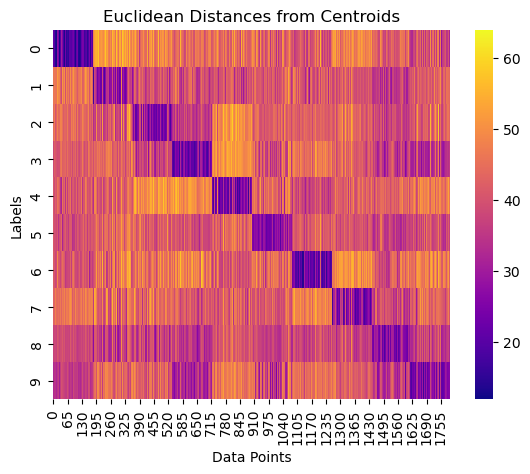

In [10]:
import pandas as pd
from nearest_centroid import NearestCentroidClassifier as NearestCentroid
from kNN import SimpleKNNClassifier as KNeighborsClassifier
from distance_metrics import (
    euclidean_distance,
    cosine_similarity,
    cosine_similarity_metric,
)
from classifiers import knn_classifier, centroid_classifier
from data_visualization import plot_digit, cosine_similarity_matrix, plot_heatmap

def confusion_matrix(predictions, labels):
    num_classes = len(np.unique(labels))
    matrix = np.zeros((num_classes, num_classes))
    for i in range(num_classes):
        for j in range(num_classes):
            matrix[i, j] = np.sum((predictions == i) & (labels == j))
    return matrix


def load_data(train_file, test_file):
    train_data = pd.read_csv(train_file, header=None)
    test_data = pd.read_csv(test_file, header=None)

    train_labels = train_data.iloc[:, -1].values
    train_data = train_data.iloc[:, :-1].values

    test_labels = test_data.iloc[:, -1].values
    test_data = test_data.iloc[:, :-1].values

    return train_data, train_labels, test_data, test_labels


def main():
    train_file = "optdigits.tra"
    test_file = "optdigits.tes"

    train_data, train_labels, test_data, test_labels = load_data(train_file, test_file)

    # k = 3

    # for metric in ["euclidean", cosine_similarity_metric]:
    #     train_accuracy, test_accuracy = knn_classifier(
    #         train_data, train_labels, test_data, test_labels, k, metric
    #     )
    #     print(
    #         f"kNN ({metric}): Train accuracy: {train_accuracy}, Test accuracy: {test_accuracy}"
    #     )

    #     train_accuracy, test_accuracy = centroid_classifier(
    #         train_data, train_labels, test_data, test_labels, metric
    #     )
    #     print(
    #         f"Centroid ({metric}): Train accuracy: {train_accuracy}, Test accuracy: {test_accuracy}"
    #     )

    # clf = NearestCentroid()
    # clf.fit(train_data, train_labels)
    # for i in range(10):
    #     plot_digit(clf.centroids[i])

    # similarity_matrix = cosine_similarity_matrix(test_data)
    # plot_heatmap(test_labels, similarity_matrix)

    heatmap_of_euclidean_distances_from_centroids(test_data, test_labels)

    # # KNN
    # knn = KNeighborsClassifier(k=3, metric="euclidean")
    # knn.fit(train_data, train_labels)
    # knn_predictions = knn.predict(test_data)
    # knn_confusion_matrix = confusion_matrix(test_labels, knn_predictions)
    # print("KNN confusion matrix (Euclidean):")
    # print(knn_confusion_matrix)
    
    # knn = KNeighborsClassifier(k=3, metric=cosine_similarity_metric)
    # knn.fit(train_data, train_labels)
    # knn_predictions = knn.predict(test_data)
    # knn_confusion_matrix = confusion_matrix(test_labels, knn_predictions)
    # print("KNN confusion matrix (Cosine similarity):")
    # print(knn_confusion_matrix)
    
    # # Centroid
    # centroid = NearestCentroid(metric="euclidean")
    # centroid.fit(train_data, train_labels)
    # centroid_predictions = centroid.predict(test_data)
    # centroid_confusion_matrix = confusion_matrix(test_labels, centroid_predictions)
    # print("Centroid confusion matrix (Euclidean):")
    # print(centroid_confusion_matrix)
    
    # centroid = NearestCentroid(metric=cosine_similarity_metric)
    # centroid.fit(train_data, train_labels)
    # centroid_predictions = centroid.predict(test_data)
    # centroid_confusion_matrix = confusion_matrix(test_labels, centroid_predictions)
    # print("Centroid confusion matrix (Cosine similarity):")
    # print(centroid_confusion_matrix)



if __name__ == "__main__":
    main()